In [1]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [2]:
test_df = pd.read_csv("data/test_data.csv", index_col=0)
test_df.reset_index(inplace=True, drop=True)
test_df

,ts,user,payment
0,2022-01-01 00:03:40.907,Kkkww7LxsEqojhi6i,101.000
1,2022-01-01 00:53:16.300,botxbGKkKNaXfKGiR,41.000
2,2022-01-01 03:50:03.295,bQbjq4PobqAFRcTy2,58.000
3,2022-01-01 06:11:30.875,SXLpG8h4PmbF4Afeg,53.000
4,2022-01-01 09:11:55.582,dLh5ehuYNXQDdPJ5C,17.052
...,...,...,...
34912,2022-12-01 16:42:55.145,Cen5CyJJPYhaG4gz2,37.246
34913,2022-12-01 17:28:24.579,RE5efDCChWYm4ap3c,58.000
34914,2022-12-01 18:33:38.598,f1286,44.306
34915,2022-12-01 20:03:53.130,a7DBGzjraCyXm6yy8,61.500


In [3]:
# get date of the holidays
holiday_list = []
for holiday in holidays.Belarus(years=[2022]).items():
    holiday_list.append(holiday[0])

In [4]:
season_dict = {1: 1,
               2: 1,
               3: 2,
               4: 2,
               5: 2,
               6: 3,
               7: 3,
               8: 3,
               9: 4,
               10: 4,
               11: 4,
               12: 1}

In [5]:
def create_time_features(df_, date_col='date_time'):
    df_[date_col] = pd.to_datetime(df_[date_col])
    
    df_['year'] = df_[date_col].dt.year
    df_['month'] = df_[date_col].dt.month
    df_['season'] = df_['month'].apply(lambda x: season_dict[x])
    df_['week_day'] = df_[date_col].dt.day_name()
    df_['is_weekend'] = np.where(
        (df_['week_day'] == "Saturday") | (df_['week_day'] == "Sunday"), 1, 0)

    df_['is_holiday'] = np.where(
        df_[date_col].dt.date.isin(holiday_list), 1, 0)
    
    df_.drop(date_col, inplace=True, axis=1)
    return df_

In [6]:
test_df["ts"] = pd.to_datetime(test_df["ts"])
test_df['date'] = test_df["ts"].dt.date
test_df = create_time_features(test_df, date_col="ts")

test_df

,user,payment,date,year,month,season,week_day,is_weekend,is_holiday
0,Kkkww7LxsEqojhi6i,101.000,2022-01-01,2022,1,1,Saturday,1,1
1,botxbGKkKNaXfKGiR,41.000,2022-01-01,2022,1,1,Saturday,1,1
2,bQbjq4PobqAFRcTy2,58.000,2022-01-01,2022,1,1,Saturday,1,1
3,SXLpG8h4PmbF4Afeg,53.000,2022-01-01,2022,1,1,Saturday,1,1
4,dLh5ehuYNXQDdPJ5C,17.052,2022-01-01,2022,1,1,Saturday,1,1
...,...,...,...,...,...,...,...,...,...
34912,Cen5CyJJPYhaG4gz2,37.246,2022-12-01,2022,12,1,Thursday,0,0
34913,RE5efDCChWYm4ap3c,58.000,2022-12-01,2022,12,1,Thursday,0,0
34914,f1286,44.306,2022-12-01,2022,12,1,Thursday,0,0
34915,a7DBGzjraCyXm6yy8,61.500,2022-12-01,2022,12,1,Thursday,0,0


# Calculate month revenue / Рассчитать ежемесячный выручку

In [114]:
month_stats = test_df.groupby(["year", "month"]).agg({"payment": ["sum", "mean"]})
month_stats.columns = ["revenue", "ARPU"]
month_stats = month_stats.reset_index()
month_stats.to_csv("data/month_revenue.csv")
month_stats

,year,month,revenue,ARPU
0,2022,1,125583.44405,38.101773
1,2022,2,122304.74531,37.912196
2,2022,3,135702.28475,37.497177
3,2022,4,129630.32295,37.175315
4,2022,5,125434.95690,38.619137
5,2022,6,107664.00200,40.983632
6,2022,7,86557.63950,40.353212
7,2022,8,100957.33599,42.276941
8,2022,9,118115.96055,44.106035
9,2022,10,112693.25433,41.738242


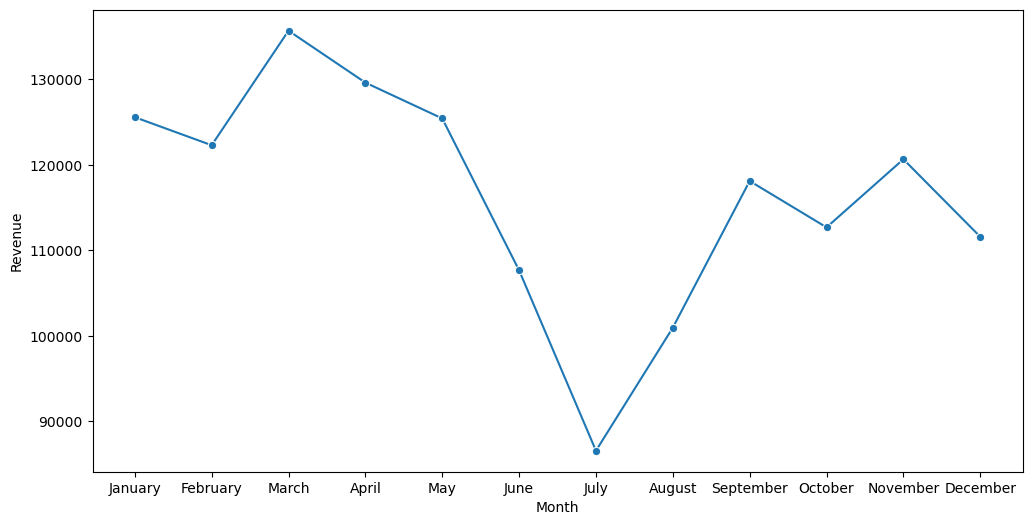

In [115]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.lineplot(data=month_stats,
             x="month",
             y="revenue",
             marker='o')
plt.xticks(range(1, 13),
                  labels=['January', 'February', 'March', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December'])
plt.xlabel("Month")
plt.ylabel("Revenue")


plt.savefig("imgs/month2revenue.png", transparent=True)

# predict income for 2023 for each month for current users only / предскажите доход на 2023 год для каждого месяца только для текущих пользователей

assuming there are no more new users / предположение, что новых пользователей больше нет

## Moving Average

In [116]:
for month in range(1, 13):
    new_row={"year": 2023, "month": month}
    month_stats = month_stats.append(new_row, ignore_index=True)

C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\251529241.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_stats = month_stats.append(new_row, ignore_index=True)
C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\251529241.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_stats = month_stats.append(new_row, ignore_index=True)
C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\251529241.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_stats = month_stats.append(new_row, ignore_index=True)
C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\251529241.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_stats = mon

In [122]:
month_stats["3-mo_MA"] = month_stats.revenue.rolling(window = 3).mean()
month_stats["3-mo_MA"][0] = month_stats["3-mo_MA"][0:3].mean()
month_stats["3-mo_MA"][1] = month_stats["3-mo_MA"][1:4].mean()
month_stats.loc[:, "revenue"] = list(month_stats.loc[:11, "revenue"])+list(month_stats.loc[:11, "3-mo_MA"])

C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\1731038178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_stats["3-mo_MA"][0] = month_stats["3-mo_MA"][0:3].mean()
C:\Users\hugom\AppData\Local\Temp\ipykernel_3188\1731038178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_stats["3-mo_MA"][1] = month_stats["3-mo_MA"][1:4].mean()


In [74]:
year_2023_pred = pd.DataFrame(
    data={"2022_revenue": month_stats["revenue"], "2023_predict_revenue": month_stats["3-mo_MA"]})
year_2023_pred.to_csv("data/2023_prediction.csv")

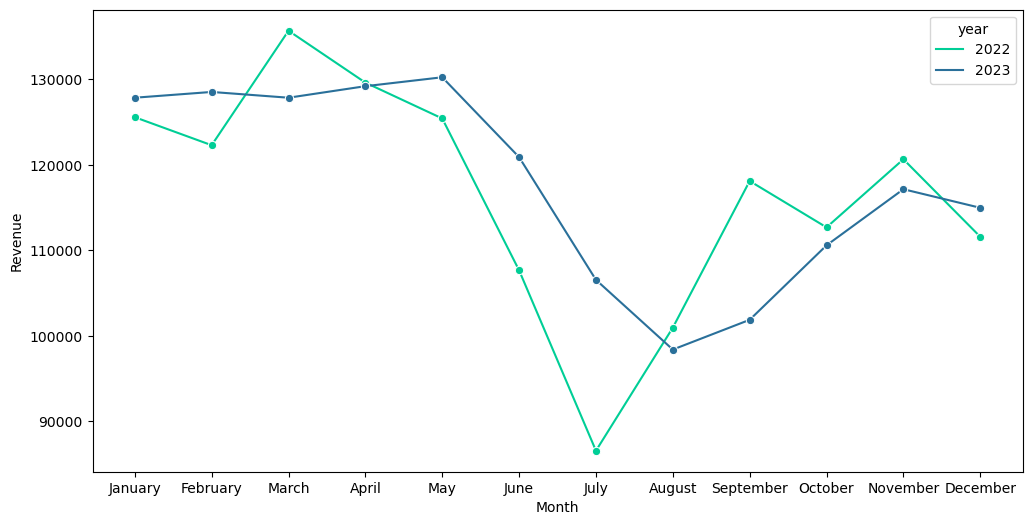

In [126]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.lineplot(data=month_stats,
             x="month",
             y="revenue",
             hue="year",
             palette=["#00ce96", "#2a709a"],
             marker='o')
plt.xticks(range(1, 13),
                  labels=['January', 'February', 'March', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December'])
plt.xlabel("Month")
plt.ylabel("Revenue")

plt.savefig("imgs/prediction.png", transparent=True)